# REINFORCE

In [15]:
""" Thins REINFORCE algorithm is Implemented by Yinyu Jin """
import torch
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
%matplotlib inline

# avoid the gym warning message
gym.logger.set_level(40)

env = gym.make('MountainCar-v0')
env = env.unwrapped
env.seed(1)

np.random.seed(1)
torch.manual_seed(1)

state_space = env.observation_space.shape[0]
action_space = env.action_space.n
eps = np.finfo(np.float32).eps.item()


class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size =24, learning_rate = 0.01): 
        super (PolicyNetwork, self).__init__()
        
        self.fc1 = nn.Linear(num_inputs, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = F.softmax(self.fc2(x), dim=1)
        return x
        
    def choose_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        act_probs = self.forward(state)
        c = Categorical(act_probs)
        action = c.sample()
        return action.item(), c.log_prob(action)
    
    def update_policy(self, returns, log_probs): 
        policy_loss = []
        for log_prob, Gt in zip (log_probs, returns):
            policy_loss.append (-log_prob * Gt)
            
        self.optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()
        
    def discounted_norm_rewards (self, rewards):
        returns = np.zeros_like(rewards)
        running_add = 0
        for t in reversed (range(len(rewards))):
            running_add = running_add * GAMMA + rewards[t]
            returns[t] = running_add
            
        #normalized discounted rewards
        returns = (returns - np.mean(returns)) / (np.std(returns)+eps)
        return returns


policy_net = PolicyNetwork(state_space,action_space, hidden_layer)


def main (episodes = 5000, GAMMA = 0.99):
    all_rewards = []
    running_rewards = []
    for episode in range(episodes): 
        state = env.reset()
        rewards = []
        log_probs = []

        while True:
            action, log_prob = policy_net.choose_action(state)
            new_state, reward, done, _ = env.step(action)
            rewards.append(reward)
            log_probs.append(log_prob)

            if done: 
                vt = policy_net.discounted_norm_rewards(rewards)
                policy_net.update_policy(vt, log_probs)
                all_rewards.append(np.sum(rewards))
                running_rewards.append(np.mean(all_rewards[-30:]))
                if episode % 100 ==0:
                    print('episode:', episode, 'total reward: ', all_rewards[-1], 'running reward:', int(running_rewards[-1]))
                break
            state = new_state
                
    return all_rewards, running_rewards, vt

all_rewards, running_rewards, vt = main()

episode: 0 total reward:  -5581.0 running reward: -5581
episode: 100 total reward:  -3349.0 running reward: -3143
episode: 200 total reward:  -3313.0 running reward: -3362
episode: 300 total reward:  -2433.0 running reward: -2427
episode: 400 total reward:  -758.0 running reward: -1368
episode: 500 total reward:  -3101.0 running reward: -1269
episode: 600 total reward:  -1022.0 running reward: -1063
episode: 700 total reward:  -1133.0 running reward: -830
episode: 800 total reward:  -569.0 running reward: -649
episode: 900 total reward:  -395.0 running reward: -554
episode: 1000 total reward:  -526.0 running reward: -622
episode: 1100 total reward:  -506.0 running reward: -517
episode: 1200 total reward:  -542.0 running reward: -550
episode: 1300 total reward:  -698.0 running reward: -437
episode: 1400 total reward:  -285.0 running reward: -351
episode: 1500 total reward:  -317.0 running reward: -362
episode: 1600 total reward:  -220.0 running reward: -515
episode: 1700 total reward:  

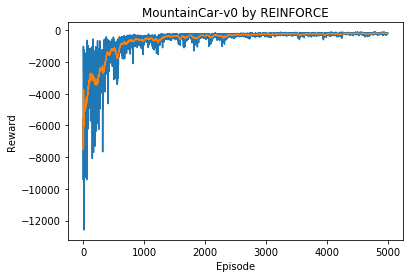

In [16]:
plt.plot(all_rewards)       
plt.plot(running_rewards)
plt.title('MountainCar-v0 by REINFORCE')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

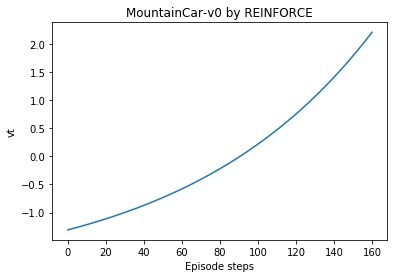

In [17]:
plt.plot(vt)
plt.title('MountainCar-v0 by REINFORCE')
plt.xlabel('Episode steps')
plt.ylabel('vt')
plt.show()